### Run this first!!

In [1]:
import os, sys

base_path = os.path.join(os.getcwd(), "..")
print(f"Base Path: {base_path}")
sys.path.append(base_path)

Base Path: /Users/swkim/Documents/coding/thesis/PROMES_colab/notebook/..


# Step 1:
First network trained to represent pod(2)+nodes(5x2)

## Step1_1: 
Naive approach

### Dataset

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd

/Users/swkim/opt/anaconda3/envs/kube-gym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
class Dataset1(Dataset):
    def __init__(self, csv_path, train=True):
        self.data = pd.read_csv(csv_path)

        if train:
            self.data = self.data.sample(frac=0.8, random_state=42)
        else:
            self.data = self.data.drop(self.data.sample(frac=0.8, random_state=42).index)

        self.data = self.transform(self.data)
        self.input = self.data[:, :-1]
        self.label = self.data[:, -1]
        # Long tensor for cross entropy loss
        self.label = torch.tensor(self.label, dtype=torch.long)

    def transform(self, data):
        return torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.input[idx], self.label[idx]

In [21]:
data_path = os.path.join(base_path, "dataset", "data_1.csv")
train_dataset1 = Dataset1(data_path, train=True)
test_dataset1 = Dataset1(data_path, train=False)
train_dataloader1 = DataLoader(train_dataset1, batch_size=32, shuffle=False)
test_dataloader1 = DataLoader(test_dataset1, batch_size=32, shuffle=False)

/var/folders/gl/n3l9mrsx1jz4xhb0rsxhj8980000gn/T/ipykernel_28534/1360674818.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label, dtype=torch.long)
/var/folders/gl/n3l9mrsx1jz4xhb0rsxhj8980000gn/T/ipykernel_28534/1360674818.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label, dtype=torch.long)


In [22]:
for batch in train_dataloader1:
    inputs, labels = batch
    print(inputs.shape, labels.shape)
    print(inputs, labels)
    break

torch.Size([32, 12]) torch.Size([32])
tensor([[0.5300, 0.8300, 0.0100, 0.8400, 0.3500, 0.0700, 0.5900, 0.5400, 0.3600,
         0.7100, 0.2300, 0.2400],
        [0.7500, 0.8700, 0.7100, 0.4800, 0.4900, 0.7500, 0.0100, 0.1100, 0.5800,
         0.9600, 0.1400, 0.4000],
        [0.2400, 0.8400, 0.6700, 0.0100, 0.2400, 0.7300, 0.8500, 0.4100, 0.1500,
         0.8600, 0.3600, 0.2900],
        [0.7200, 0.2800, 0.5000, 0.0800, 0.1300, 0.4200, 0.8200, 0.1100, 0.8400,
         1.0000, 0.4900, 0.3100],
        [0.3300, 0.2700, 0.4000, 0.2000, 0.2400, 0.8600, 0.9800, 0.0700, 0.7000,
         0.7900, 0.2800, 0.2700],
        [0.1300, 0.3500, 0.2000, 0.2400, 0.3300, 0.7800, 0.6100, 0.9200, 0.4300,
         0.3200, 0.4500, 0.1100],
        [0.5900, 0.8000, 0.8100, 0.6900, 0.5100, 0.8400, 0.1500, 0.8600, 0.9900,
         0.1300, 0.3100, 0.3100],
        [0.0700, 0.4100, 0.4900, 0.1200, 0.5600, 0.7200, 0.0600, 0.1700, 0.0400,
         0.3200, 0.0000, 0.0000],
        [0.1000, 0.4400, 0.1700, 0.3000, 0

### Model

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [24]:
net1 = Net1()
print(net1)

Net1(
  (fc1): Linear(in_features=12, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


In [25]:
# Training
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)

In [26]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        # print(f"output: {output}")
        # print(f"target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

In [27]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [28]:
epochs = 100
test_acc = 0
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(net1, train_dataloader1, criterion, optimizer)
    test_loss, test_acc = test(net1, test_dataloader1, criterion)
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    if test_acc > 97:
        break

Epoch 1: Train Loss: 0.3443, Train Acc: 87.32%, Test Loss: 0.2264, Test Acc: 91.65%
Epoch 2: Train Loss: 0.2021, Train Acc: 92.54%, Test Loss: 0.1862, Test Acc: 92.91%
Epoch 3: Train Loss: 0.1665, Train Acc: 93.72%, Test Loss: 0.1523, Test Acc: 94.02%
Epoch 4: Train Loss: 0.1409, Train Acc: 94.56%, Test Loss: 0.1314, Test Acc: 94.76%
Epoch 5: Train Loss: 0.1237, Train Acc: 95.14%, Test Loss: 0.1156, Test Acc: 95.35%
Epoch 6: Train Loss: 0.1113, Train Acc: 95.57%, Test Loss: 0.1071, Test Acc: 95.58%
Epoch 7: Train Loss: 0.1028, Train Acc: 95.89%, Test Loss: 0.0981, Test Acc: 95.96%
Epoch 8: Train Loss: 0.0969, Train Acc: 96.13%, Test Loss: 0.0913, Test Acc: 96.25%
Epoch 9: Train Loss: 0.0921, Train Acc: 96.33%, Test Loss: 0.0850, Test Acc: 96.51%
Epoch 10: Train Loss: 0.0885, Train Acc: 96.48%, Test Loss: 0.0801, Test Acc: 96.74%
Epoch 11: Train Loss: 0.0854, Train Acc: 96.61%, Test Loss: 0.0793, Test Acc: 96.76%
Epoch 12: Train Loss: 0.0829, Train Acc: 96.71%, Test Loss: 0.0788, Test A

In [29]:
# predict the score for each action
def predict_score(data, model=net1):
    model.eval()
    if not torch.is_tensor(data):
        data = torch.tensor(data, dtype=torch.float32)
    output = model(data)
    # Softmax
    output = F.softmax(output, dim=1)
    return output

In [30]:
def predict(data, model=net1):
    model.eval()
    with torch.no_grad():
        # if data is not torch tensor, convert it to torch tensor
        if not torch.is_tensor(data):
            data = torch.tensor(data, dtype=torch.float32)
        output = model(data)
        return output.argmax(dim=1, keepdim=True)


In [31]:
sample1 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.0, 0.0]]
sample2 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.6, 0.7]]

In [32]:
predict(sample1)

tensor([[0]])

In [33]:
predict(sample2)

tensor([[5]])

In [34]:
predict_score(sample1)

tensor([[9.9976e-01, 2.5638e-28, 8.6838e-24, 1.5220e-23, 1.2097e-21, 2.3961e-04]],
       grad_fn=<SoftmaxBackward0>)

In [35]:
predict_score(sample2)

tensor([[3.0590e-08, 0.0000e+00, 4.5630e-18, 2.7679e-34, 1.1791e-39, 1.0000e+00]],
       grad_fn=<SoftmaxBackward0>)

In [36]:
test = predict_score(sample2)
# Softmax
test = F.softmax(test, dim=1)
print(test)

tensor([[0.1296, 0.1296, 0.1296, 0.1296, 0.1296, 0.3522]],
       grad_fn=<SoftmaxBackward0>)


In [38]:
# Save the model
# torch.save(net1, 'net1.pt')
torch.save(net1.state_dict(), 'net1.pt')

## Step1_2: 
Pod + Nodes(5) as inputs, Outputting the best action, Comparing with default scheduler label

### Dataset

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd

In [8]:
class Dataset2(Dataset):
    def __init__(self, csv_path, train=True):
        self.data = pd.read_csv(csv_path)
        # Drop the row which has 0 for the last -2, -3 columns
        # self.data = self.data.drop(self.data[(self.data.iloc[:, -2] == 0) & (self.data.iloc[:, -3] == 0)].index)

        if train:
            self.data = self.data.sample(frac=0.8, random_state=42)
        else:
            self.data = self.data.drop(self.data.sample(frac=0.8, random_state=42).index)

        self.data = self.transform(self.data)
        self.input1 = self.data[:, :-3]
        self.input2 = self.data[:, -3:-1]
        self.label = self.data[:, -1]
        # Long tensor for cross entropy loss
        self.label = torch.tensor(self.label, dtype=torch.long)

    def transform(self, data):
        return torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.input1[idx], self.input2[idx], self.label[idx]

In [9]:
data_path = os.path.join(base_path, "dataset", "data_1.csv")
train_dataset2 = Dataset2(data_path, train=True)
test_dataset2 = Dataset2(data_path, train=False)
train_dataloader2 = DataLoader(train_dataset2, batch_size=32, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

/var/folders/gl/n3l9mrsx1jz4xhb0rsxhj8980000gn/T/ipykernel_4858/1255837556.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label, dtype=torch.long)
/var/folders/gl/n3l9mrsx1jz4xhb0rsxhj8980000gn/T/ipykernel_4858/1255837556.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.label = torch.tensor(self.label, dtype=torch.long)


In [10]:
for batch in train_dataloader2:
    input1, input2, labels = batch
    print(input1.shape, input2.shape, labels.shape)
    print(f"input1: {input1}\ninput2: {input2}\nlabels: {labels}")
    break

torch.Size([32, 10]) torch.Size([32, 2]) torch.Size([32])
input1: tensor([[0.5300, 0.8300, 0.0100, 0.8400, 0.3500, 0.0700, 0.5900, 0.5400, 0.3600,
         0.7100],
        [0.7500, 0.8700, 0.7100, 0.4800, 0.4900, 0.7500, 0.0100, 0.1100, 0.5800,
         0.9600],
        [0.2400, 0.8400, 0.6700, 0.0100, 0.2400, 0.7300, 0.8500, 0.4100, 0.1500,
         0.8600],
        [0.7200, 0.2800, 0.5000, 0.0800, 0.1300, 0.4200, 0.8200, 0.1100, 0.8400,
         1.0000],
        [0.3300, 0.2700, 0.4000, 0.2000, 0.2400, 0.8600, 0.9800, 0.0700, 0.7000,
         0.7900],
        [0.1300, 0.3500, 0.2000, 0.2400, 0.3300, 0.7800, 0.6100, 0.9200, 0.4300,
         0.3200],
        [0.5900, 0.8000, 0.8100, 0.6900, 0.5100, 0.8400, 0.1500, 0.8600, 0.9900,
         0.1300],
        [0.0700, 0.4100, 0.4900, 0.1200, 0.5600, 0.7200, 0.0600, 0.1700, 0.0400,
         0.3200],
        [0.1000, 0.4400, 0.1700, 0.3000, 0.5000, 0.9500, 0.3400, 0.8300, 0.2700,
         0.9400],
        [0.8800, 0.6200, 0.9900, 0.1800, 0.

### Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1_10 = nn.Linear(10, 16) # 5 Nodes status (CPU, Memory)
        self.fc1_2 = nn.Linear(2, 16)   # Pod quota (CPU, Memory)
        self.fc2 = nn.Linear(32, 16)    # Concatenated vector
        self.fc3 = nn.Linear(16, 6)     # 6-sized vector

    def forward(self, x10, x2):
        x10 = F.relu(self.fc1_10(x10))  
        x2 = F.relu(self.fc1_2(x2))
        x = torch.cat((x10, x2), dim=1) 
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)     
        # x = F.softmax(self.fc3(x), dim=1)
        # x = torch.argmax(x, dim=1)
        return x

net2 = Net2()
print(net2)

Net2(
  (fc1_10): Linear(in_features=10, out_features=16, bias=True)
  (fc1_2): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=6, bias=True)
)


In [ ]:
# Training
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr=0.001)

In [ ]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data10, data2, target in train_loader:
        optimizer.zero_grad()
        output = model(data10, data2)
        # print(f"output: {output}")
        # print(f"target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data2.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data10, data2, target in test_loader:
            output = model(data10, data2)
            test_loss += criterion(output, target).item() * data2.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [ ]:
epochs = 100
test_acc = 0
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(net2, train_dataloader2, criterion, optimizer)
    test_loss, test_acc = test(net2, test_dataloader2, criterion)
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    if test_acc > 92:
        break

Epoch 1: Train Loss: 0.6472, Train Acc: 75.28%, Test Loss: 0.5846, Test Acc: 77.29%
Epoch 2: Train Loss: 0.5814, Train Acc: 77.40%, Test Loss: 0.5805, Test Acc: 77.37%
Epoch 3: Train Loss: 0.5673, Train Acc: 77.82%, Test Loss: 0.5170, Test Acc: 79.72%
Epoch 4: Train Loss: 0.4975, Train Acc: 80.37%, Test Loss: 0.4449, Test Acc: 82.50%
Epoch 5: Train Loss: 0.4269, Train Acc: 83.34%, Test Loss: 0.4261, Test Acc: 83.37%
Epoch 6: Train Loss: 0.4225, Train Acc: 83.47%, Test Loss: 0.4240, Test Acc: 83.40%
Epoch 7: Train Loss: 0.4209, Train Acc: 83.51%, Test Loss: 0.4226, Test Acc: 83.47%
Epoch 8: Train Loss: 0.4197, Train Acc: 83.54%, Test Loss: 0.4211, Test Acc: 83.49%
Epoch 9: Train Loss: 0.4186, Train Acc: 83.57%, Test Loss: 0.4196, Test Acc: 83.55%
Epoch 10: Train Loss: 0.4177, Train Acc: 83.61%, Test Loss: 0.4183, Test Acc: 83.59%
Epoch 11: Train Loss: 0.4166, Train Acc: 83.63%, Test Loss: 0.4168, Test Acc: 83.64%
Epoch 12: Train Loss: 0.4152, Train Acc: 83.66%, Test Loss: 0.4156, Test A

## Step1_3: 
Pod + Nodes(5) as inputs, Outputting the 6 actions' confidences, Comparing with default scheduler score

### Dataset

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

import pandas as pd

In [13]:
class Dataset3(Dataset):
    def __init__(self, csv_path, train=True):
        self.data = pd.read_csv(csv_path)
        # Drop the row which has 0 for the last -2, -3 columns
        # self.data = self.data.drop(self.data[(self.data.iloc[:, -2] == 0) & (self.data.iloc[:, -3] == 0)].index)

        if train:
            self.data = self.data.sample(frac=0.8, random_state=42)
        else:
            self.data = self.data.drop(self.data.sample(frac=0.8, random_state=42).index)

        self.data = self.transform(self.data)
        self.input1 = self.data[:, :-8]
        self.input2 = self.data[:, -8:-6]
        self.label = self.data[:, -6:]
        # Multiply by 100
        self.label = self.label * 100

    def transform(self, data):
        return torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.input1[idx], self.input2[idx], self.label[idx]

In [14]:
import os

data_path = os.path.join(base_path, "dataset", "data_2.csv")
train_dataset3 = Dataset3(data_path, train=True)
test_dataset3 = Dataset3(data_path, train=False)
train_dataloader3 = DataLoader(train_dataset3, batch_size=32, shuffle=False)
test_dataloader3 = DataLoader(test_dataset3, batch_size=32, shuffle=False)

In [15]:
for batch in train_dataloader3:
    input1, input2, labels = batch
    print(input1.shape, input2.shape, labels.shape)
    print(f"input1: {input1}\ninput2: {input2}\nlabels: {labels}")
    break

torch.Size([32, 10]) torch.Size([32, 2]) torch.Size([32, 6])
input1: tensor([[0.4000, 0.2700, 0.8800, 0.6200, 0.8200, 0.3000, 0.0200, 0.6800, 0.1100,
         0.8800],
        [0.3700, 0.1300, 0.0800, 0.5100, 0.6800, 0.5100, 0.6100, 0.2700, 0.1900,
         0.1300],
        [0.3100, 0.2000, 0.7700, 0.0400, 0.2000, 0.5300, 0.4000, 0.4500, 0.8100,
         0.9800],
        [0.6100, 0.4300, 0.0000, 0.8800, 0.1000, 0.7200, 0.6400, 0.2900, 0.4300,
         0.5300],
        [0.6300, 0.7300, 0.1000, 0.3700, 0.5500, 0.0300, 0.8800, 0.9600, 0.6100,
         0.3800],
        [0.0900, 0.9200, 0.5500, 0.1800, 0.1900, 0.2800, 0.4200, 0.8500, 0.3100,
         0.5900],
        [0.5800, 0.2700, 0.2100, 0.5500, 0.5000, 0.4200, 0.5500, 0.4900, 0.7500,
         0.9000],
        [0.3900, 0.0600, 0.0700, 0.6000, 0.4800, 0.1900, 0.0100, 0.7700, 0.3200,
         0.1700],
        [0.5100, 0.9700, 0.8700, 0.8200, 0.7300, 0.9200, 0.6700, 0.0700, 0.0800,
         0.1400],
        [0.1200, 0.7000, 0.3400, 0.0900,

### Model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.fc1_1 = nn.Linear(10, 16) # 5 Nodes status (CPU, Memory)
        self.fc1_2 = nn.Linear(2, 16)   # Pod quota (CPU, Memory)
        self.fc2 = nn.Linear(32, 16)    # Concatenated vector
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 6)     # 6-sized vector

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1_1(x1))  
        x2 = F.relu(self.fc1_2(x2))
        x = torch.cat((x1, x2), dim=1) 
        x = F.relu(self.fc2(x))  
        x = F.relu(self.fc3(x))
        x = self.fc4(x)     
        # x = F.softmax(self.fc3(x), dim=1)
        # x = torch.argmax(x, dim=1)
        return x

net3 = Net3()
print(net3)

Net3(
  (fc1_1): Linear(in_features=10, out_features=16, bias=True)
  (fc1_2): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=6, bias=True)
)


In [17]:
# Training
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net3.parameters(), lr=0.001)

In [18]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data10, data2, target in train_loader:
        optimizer.zero_grad()
        output = model(data10, data2)
        # print(f"output: {output}")
        # print(f"target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data2.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

In [19]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data10, data2, target in test_loader:
            output = model(data10, data2)
            test_loss += criterion(output, target).item() * data2.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [20]:
epochs = 100
test_acc = 0
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(net3, train_dataloader3, criterion, optimizer)
    test_loss, test_acc = test(net3, test_dataloader3, criterion)
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    if test_acc > 95:
        break

Epoch 1: Train Loss: 213.9471, Train Acc: 38.64%, Test Loss: 123.4398, Test Acc: 53.72%
Epoch 2: Train Loss: 104.6910, Train Acc: 59.83%, Test Loss: 93.4085, Test Acc: 64.53%
Epoch 3: Train Loss: 79.0497, Train Acc: 71.93%, Test Loss: 72.1699, Test Acc: 73.66%
Epoch 4: Train Loss: 72.2054, Train Acc: 73.63%, Test Loss: 71.1593, Test Acc: 73.66%
Epoch 5: Train Loss: 71.5058, Train Acc: 73.61%, Test Loss: 70.7268, Test Acc: 73.65%
Epoch 6: Train Loss: 71.2602, Train Acc: 73.60%, Test Loss: 70.5872, Test Acc: 73.63%
Epoch 7: Train Loss: 71.1645, Train Acc: 73.62%, Test Loss: 70.5200, Test Acc: 73.64%
Epoch 8: Train Loss: 71.1026, Train Acc: 73.64%, Test Loss: 70.4945, Test Acc: 73.65%
Epoch 9: Train Loss: 71.0479, Train Acc: 73.64%, Test Loss: 70.4377, Test Acc: 73.66%
Epoch 10: Train Loss: 64.5755, Train Acc: 74.83%, Test Loss: 56.7772, Test Acc: 76.39%
Epoch 11: Train Loss: 57.0468, Train Acc: 76.28%, Test Loss: 56.6773, Test Acc: 76.41%
Epoch 12: Train Loss: 56.9755, Train Acc: 76.29%,

In [27]:
# Save the model's weight
torch.save(net3.state_dict(), os.path.join(base_path, "kube_mm_scheduler", "weight", "net3.pt"))

In [ ]:
# # Exclude the last layer(fc4)
# net3_pretrained = nn.Sequential(*list(net3.children())[:-1])
# net3_pretrained

In [21]:
sample1 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.0, 0.0]]
sample2 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.6, 0.7]]

In [22]:
# predict the score for each action
def predict_score(data, model=net3):
    model.eval()
    if not torch.is_tensor(data):
        data = torch.tensor(data, dtype=torch.float32)
    data10 = data[:, :-2]
    data2 = data[:, -2:]
    output = model(data10, data2)
    # Round up at the 4th decimal point
    output = torch.round(output * 10000) / 10000
    # # Softmax
    # output = F.softmax(output, dim=1)
    # print(output)
    return output

def predict(data, model=net3):
    model.eval()
    with torch.no_grad():
        # if data is not torch tensor, convert it to torch tensor
        if not torch.is_tensor(data):
            data = torch.tensor(data, dtype=torch.float32)
        data10 = data[:, :-2]
        data2 = data[:, -2:]
        output = model(data10, data2)
        return output.argmax(dim=1, keepdim=True)


In [23]:
predict(sample1)

tensor([[0]])

In [24]:
predict_score(sample1)

tensor([[ 9.9552e+01, -2.9280e-01,  2.4490e-01,  3.1940e-01, -8.0000e-02,
          2.0930e-01]], grad_fn=<DivBackward0>)

In [25]:
predict(sample2)

tensor([[5]])

In [26]:
predict_score(sample2)

tensor([[-2.0031, 23.0833, 37.8686, 15.5485, 26.9847, 65.2813]],
       grad_fn=<DivBackward0>)

# Step 2:
Second network utilizing the first network and takes node(2) additionally to get the score of the node.
The label score should be either default scheduler's score or the first networks unit value.

### Dataset

In [28]:
class Dataset4(Dataset):
    def __init__(self, csv_path, train=True):
        self.data = pd.read_csv(csv_path)
        # Drop the row which has 0 for the last -2, -3 columns
        # self.data = self.data.drop(self.data[(self.data.iloc[:, -2] == 0) & (self.data.iloc[:, -3] == 0)].index)

        if train:
            self.data = self.data.sample(frac=0.8, random_state=42)
        else:
            self.data = self.data.drop(self.data.sample(frac=0.8, random_state=42).index)

        self.data = self.transform(self.data)
        self.input1 = self.data[:, :-5]
        self.input2 = self.data[:, -5:-3]
        self.input3 = self.data[:, -3:-1]
        self.label = self.data[:, -1]
        # multiply by 100
        self.label = self.label * 100

    def transform(self, data):
        return torch.tensor(data.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.input1[idx], self.input2[idx], self.input3[idx], self.label[idx]

In [31]:
data_path = os.path.join(base_path, "dataset", "data_3.csv")
train_dataset4 = Dataset4(data_path, train=True)
test_dataset4 = Dataset4(data_path, train=False)
train_dataloader4 = DataLoader(train_dataset4, batch_size=32, shuffle=False)
test_dataloader4 = DataLoader(test_dataset4, batch_size=32, shuffle=False)

In [33]:
for batch in train_dataloader4:
    input1, input2, input3, labels = batch
    print(input1.shape, input2.shape, labels.shape)
    print(f"input1: {input1}\ninput2: {input2}\ninput3: {input3}\nlabels: {labels}")
    break

torch.Size([32, 10]) torch.Size([32, 2]) torch.Size([32])
input1: tensor([[0.7100, 0.4700, 0.2000, 0.6900, 0.9900, 0.9400, 0.6100, 0.9700, 0.5300,
         0.1700],
        [0.3700, 0.2900, 0.6400, 0.7600, 0.2800, 0.6400, 0.5400, 0.1500, 0.0800,
         0.4000],
        [0.8400, 0.5600, 0.4300, 0.7900, 0.3100, 0.4700, 0.0500, 0.5200, 0.7500,
         0.1700],
        [0.0700, 0.1000, 0.1400, 0.0900, 0.3400, 0.8200, 0.5900, 0.9000, 0.8800,
         0.7600],
        [0.7100, 0.8000, 0.9600, 0.8800, 0.4900, 0.7200, 0.6500, 0.7100, 0.7600,
         0.9700],
        [0.6500, 0.9100, 0.6000, 0.6900, 0.6200, 0.2100, 0.6000, 0.5300, 0.2500,
         0.9000],
        [0.5300, 0.8300, 0.1800, 0.0600, 0.1900, 0.4200, 0.0800, 0.2000, 0.1800,
         0.2500],
        [0.1300, 0.5900, 0.4100, 0.6400, 0.0200, 0.9200, 0.1800, 0.4000, 0.9300,
         0.7300],
        [0.0600, 0.8800, 0.1500, 0.3800, 0.6200, 0.1100, 0.3000, 0.4800, 0.1600,
         0.8000],
        [0.9900, 0.8600, 0.7300, 0.0700, 0.

### Model

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from kube_mm_scheduler.model.net3 import Net3

class Net3_(Net3):
    def __init__(self):
        super(Net3_, self).__init__()
        self.fc4 = None

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1_1(x1))  
        x2 = F.relu(self.fc1_2(x2))
        x = torch.cat((x1, x2), dim=1) 
        x = F.relu(self.fc2(x))  
        # x = F.relu(self.fc3(x)) # Should I use the activation function here?
        x = self.fc3(x)
        return x


# Reuse Net3_pretrained to process input1 and input2
# Then concatenate the output with input3
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()

        # Option1 : Use the Net3 as it is
        # self.net3 = Net3()

        # Option2 : Use the Net3 except the last layer allowing to take 2 inputs
        # self.net3 = nn.Sequential(*list(net3.children())[:-1])

        # Option3 : Use the Net3 except the last layer allowing to take 2 inputs
        self.net3_ = Net3_()
        
    
        self.fc1_3 = nn.Linear(2, 16)   # Selected node state (CPU, Memory)
        # self.fc2 = nn.Linear(22, 16)    # Concatenated vector (Option1)
        self.fc2 = nn.Linear(32, 16)    # Concatenated vector (Option2 and Option3)
        self.fc3 = nn.Linear(16, 1)     # 1-sized vector

    def forward(self, x1, x2, x3):
        x12 = self.net3_(x1, x2)
        x3 = F.relu(self.fc1_3(x3))
        x = torch.cat((x12, x3), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [60]:
net4 = Net4()

# Option1: Load weight from net3
# net4.net3.load_state_dict(net3.state_dict())

# Option2: Load weight from net3_pretrained
# net4.net3.load_state_dict(net3_pretrained.state_dict())

# Option3: Load weight from net3
net3_state_dict = net3.state_dict()
net3_state_dict.pop('fc4.weight')
net3_state_dict.pop('fc4.bias')
net4.net3_.load_state_dict(net3_state_dict)

# Freeze net3
for param in net4.net3_.parameters():
    param.requires_grad = False

print(net4)

Net4(
  (net3_): Net3_(
    (fc1_1): Linear(in_features=10, out_features=16, bias=True)
    (fc1_2): Linear(in_features=2, out_features=16, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=16, bias=True)
    (fc4): None
  )
  (fc1_3): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [61]:
for name, param in net4.named_parameters():
    if not param.requires_grad:
        print(name, ": frozen.")
    else:
        print(name, ": traintable")

net3_.fc1_1.weight : frozen.
net3_.fc1_1.bias : frozen.
net3_.fc1_2.weight : frozen.
net3_.fc1_2.bias : frozen.
net3_.fc2.weight : frozen.
net3_.fc2.bias : frozen.
net3_.fc3.weight : frozen.
net3_.fc3.bias : frozen.
fc1_3.weight : traintable
fc1_3.bias : traintable
fc2.weight : traintable
fc2.bias : traintable
fc3.weight : traintable
fc3.bias : traintable


In [62]:
n_total_params = sum(p.numel() for p in net4.parameters())
n_trainable_params = sum(p.numel() for p in net4.parameters() if p.requires_grad)
print(f"Total params: {n_total_params}, Trainable params: {n_trainable_params}")

Total params: 1617, Trainable params: 593


In [63]:
# Training
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net4.parameters(), lr=0.001)

In [64]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    for data1, data2, data3, target in train_loader:
        # Increase the dimension of target
        # target = target.unsqueeze(1)
        optimizer.zero_grad()
        output = model(data1, data2, data3)
        output = output.squeeze(1)
        # print(f"output: {output}")
        # print(f"target: {target}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data2.size(0)
        pred = output.detach()

        # Count the number of correct predictions
        # If diff is less than 3 percent, it is correct
        diff = torch.abs(pred - target)
        # print(diff)
        correct += torch.sum(diff < 1).item()

        # print(f"correct: {correct}")

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    # print(f"accuracy = 100. * {correct} / {len(train_loader.dataset)} = {accuracy}")
    return train_loss, accuracy

In [65]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data1, data2, data3, target in test_loader:
            # Increase the dimension of target
            # target = target.unsqueeze(1)
            output = model(data1, data2, data3)
            output = output.squeeze(1)
            test_loss += criterion(output, target).item() * data2.size(0)
            pred = output.detach()

            # Count the number of correct predictions
            # If diff is less than 3 percent, it is correct
            diff = torch.abs(pred - target)
            correct += torch.sum(diff < 1).item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [ ]:
epochs = 20
test_acc = 0
for epoch in range(1, epochs+1):
    train_loss, train_acc = train(net4, train_dataloader4, criterion, optimizer)
    test_loss, test_acc = test(net4, test_dataloader4, criterion)
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    # if test_acc > 95:
    #     break

In [67]:
# Save the model's weight
torch.save(net4.state_dict(), os.path.join(base_path, "kube_mm_scheduler", "weight", "net4.pt"))

# Step 3:
Using model based on Net4 which is designed for one node,
takes pod(2)+nodes(5)+ node(2)*5, outputting the confidence(0~100) for each node
Reusing the trained weights and network

### Dataset: Using same dataset and dataloader as net4

### Model: Based on net4, make new module

In [80]:
import torch.nn as nn
import torch.nn.functional as F
from kube_mm_scheduler.model.net3 import Net3

class Net3_(Net3):
    def __init__(self):
        super(Net3_, self).__init__()
        self.fc4 = None

    def forward(self, x1, x2):
        x1 = F.relu(self.fc1_1(x1))  
        x2 = F.relu(self.fc1_2(x2))
        x = torch.cat((x1, x2), dim=1) 
        x = F.relu(self.fc2(x))  
        x = F.relu(self.fc3(x))
        return x

# Reuse Net4 to process input1 and input2
# We will take 5 nodes' state which is same as input3
# And will concatenate each output with the output from Net3_
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.net3_ = Net3_()

        self.fc1_3_1 = nn.Linear(2, 16)   # Node1 state (CPU, Memory)
        self.fc1_3_2 = nn.Linear(2, 16)   # Node2 state (CPU, Memory)
        self.fc1_3_3 = nn.Linear(2, 16)   # Node3 state (CPU, Memory)
        self.fc1_3_4 = nn.Linear(2, 16)   # Node4 state (CPU, Memory)
        self.fc1_3_5 = nn.Linear(2, 16)   # Node5 state (CPU, Memory)

        # Node 1
        self.fc2_1 = nn.Linear(32, 16)
        self.fc3_1 = nn.Linear(16, 1)

        # Node 2
        self.fc2_2 = nn.Linear(32, 16)
        self.fc3_2 = nn.Linear(16, 1)

        # Node 3
        self.fc2_3 = nn.Linear(32, 16)
        self.fc3_3 = nn.Linear(16, 1)

        # Node 4
        self.fc2_4 = nn.Linear(32, 16)
        self.fc3_4 = nn.Linear(16, 1)

        # Node 5
        self.fc2_5 = nn.Linear(32, 16)
        self.fc3_5 = nn.Linear(16, 1)

    def forward(self, x1, x2):
        x12 = self.net3_(x1, x2)
        
        x3_1 = F.relu(self.fc1_3_1(x1[:, :2]))
        x3_2 = F.relu(self.fc1_3_2(x1[:, 2:4]))
        x3_3 = F.relu(self.fc1_3_3(x1[:, 4:6]))
        x3_4 = F.relu(self.fc1_3_4(x1[:, 6:8]))
        x3_5 = F.relu(self.fc1_3_5(x1[:, 8:10]))

        x4_1 = torch.cat((x12, x3_1), dim=1)
        x4_2 = torch.cat((x12, x3_2), dim=1)
        x4_3 = torch.cat((x12, x3_3), dim=1)
        x4_4 = torch.cat((x12, x3_4), dim=1)
        x4_5 = torch.cat((x12, x3_5), dim=1)

        x5_1 = F.relu(self.fc2_1(x4_1))
        x5_2 = F.relu(self.fc2_2(x4_2))
        x5_3 = F.relu(self.fc2_3(x4_3))
        x5_4 = F.relu(self.fc2_4(x4_4))
        x5_5 = F.relu(self.fc2_5(x4_5))

        # x5_1 = self.fc2_1(x4_1)
        # x5_2 = self.fc2_2(x4_2)
        # x5_3 = self.fc2_3(x4_3)
        # x5_4 = self.fc2_4(x4_4)
        # x5_5 = self.fc2_5(x4_5)

        x6_1 = self.fc3_1(x5_1)
        x6_2 = self.fc3_2(x5_2)
        x6_3 = self.fc3_3(x5_3)
        x6_4 = self.fc3_4(x5_4)
        x6_5 = self.fc3_5(x5_5)

        x7 = torch.cat((x6_1, x6_2, x6_3, x6_4, x6_5), dim=1)
        # x7 = torch.cat((x5_1, x5_2, x5_3, x5_4, x5_5), dim=1)
        return x7

        

In [81]:
net5 = Net5()

# Load weight from net3
net3_state_dict = net3.state_dict()
net3_state_dict.pop('fc4.weight')
net3_state_dict.pop('fc4.bias')
net5.net3_.load_state_dict(net3_state_dict)

# Freeze net3
for param in net5.net3_.parameters():
    param.requires_grad = False

# Load weight from net4
net4_state_dict = torch.load(os.path.join(base_path, "kube_mm_scheduler", "weight", "net4.pt"))

fc1_3_weight = net4_state_dict['fc1_3.weight']
fc1_3_bias = net4_state_dict['fc1_3.bias']

fc2_weight = net4_state_dict['fc2.weight']
fc2_bias = net4_state_dict['fc2.bias']

fc3_weight = net4_state_dict['fc3.weight']
fc3_bias = net4_state_dict['fc3.bias']

net5.fc1_3_1.weight.data = fc1_3_weight
net5.fc1_3_1.bias.data = fc1_3_bias

net5.fc1_3_2.weight.data = fc1_3_weight
net5.fc1_3_2.bias.data = fc1_3_bias

net5.fc1_3_3.weight.data = fc1_3_weight
net5.fc1_3_3.bias.data = fc1_3_bias

net5.fc1_3_4.weight.data = fc1_3_weight
net5.fc1_3_4.bias.data = fc1_3_bias

net5.fc1_3_5.weight.data = fc1_3_weight
net5.fc1_3_5.bias.data = fc1_3_bias

net5.fc2_1.weight.data = fc2_weight
net5.fc2_1.bias.data = fc2_bias

net5.fc2_2.weight.data = fc2_weight
net5.fc2_2.bias.data = fc2_bias

net5.fc2_3.weight.data = fc2_weight
net5.fc2_3.bias.data = fc2_bias

net5.fc2_4.weight.data = fc2_weight
net5.fc2_4.bias.data = fc2_bias

net5.fc2_5.weight.data = fc2_weight
net5.fc2_5.bias.data = fc2_bias

# net5.fc3_1.weight.data = fc3_weight
# net5.fc3_1.bias.data = fc3_bias

# net5.fc3_2.weight.data = fc3_weight
# net5.fc3_2.bias.data = fc3_bias

# net5.fc3_3.weight.data = fc3_weight
# net5.fc3_3.bias.data = fc3_bias

# net5.fc3_4.weight.data = fc3_weight
# net5.fc3_4.bias.data = fc3_bias

# net5.fc3_5.weight.data = fc3_weight
# net5.fc3_5.bias.data = fc3_bias

print(net5)

Net5(
  (net3_): Net3_(
    (fc1_1): Linear(in_features=10, out_features=16, bias=True)
    (fc1_2): Linear(in_features=2, out_features=16, bias=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=16, bias=True)
    (fc4): None
  )
  (fc1_3_1): Linear(in_features=2, out_features=16, bias=True)
  (fc1_3_2): Linear(in_features=2, out_features=16, bias=True)
  (fc1_3_3): Linear(in_features=2, out_features=16, bias=True)
  (fc1_3_4): Linear(in_features=2, out_features=16, bias=True)
  (fc1_3_5): Linear(in_features=2, out_features=16, bias=True)
  (fc2_1): Linear(in_features=32, out_features=16, bias=True)
  (fc3_1): Linear(in_features=16, out_features=1, bias=True)
  (fc2_2): Linear(in_features=32, out_features=16, bias=True)
  (fc3_2): Linear(in_features=16, out_features=1, bias=True)
  (fc2_3): Linear(in_features=32, out_features=16, bias=True)
  (fc3_3): Linear(in_features=16, out_features=1, bias=True)
  (fc2_4): Linear(in_

In [82]:
# Network summary
for name, param in net5.named_parameters():
    if not param.requires_grad:
        print(name, ": frozen.")
    else:
        print(name, ": traintable")

net3_.fc1_1.weight : frozen.
net3_.fc1_1.bias : frozen.
net3_.fc1_2.weight : frozen.
net3_.fc1_2.bias : frozen.
net3_.fc2.weight : frozen.
net3_.fc2.bias : frozen.
net3_.fc3.weight : frozen.
net3_.fc3.bias : frozen.
fc1_3_1.weight : traintable
fc1_3_1.bias : traintable
fc1_3_2.weight : traintable
fc1_3_2.bias : traintable
fc1_3_3.weight : traintable
fc1_3_3.bias : traintable
fc1_3_4.weight : traintable
fc1_3_4.bias : traintable
fc1_3_5.weight : traintable
fc1_3_5.bias : traintable
fc2_1.weight : traintable
fc2_1.bias : traintable
fc3_1.weight : traintable
fc3_1.bias : traintable
fc2_2.weight : traintable
fc2_2.bias : traintable
fc3_2.weight : traintable
fc3_2.bias : traintable
fc2_3.weight : traintable
fc2_3.bias : traintable
fc3_3.weight : traintable
fc3_3.bias : traintable
fc2_4.weight : traintable
fc2_4.bias : traintable
fc3_4.weight : traintable
fc3_4.bias : traintable
fc2_5.weight : traintable
fc2_5.bias : traintable
fc3_5.weight : traintable
fc3_5.bias : traintable


In [83]:
# Sample input from test_dataloader3
# 0:10 -> Node state
# 10:12 -> Pod quota
# 12: -> Label confidence for each node

# Load sample data
for batch in test_dataloader3:
    input1, input2, labels = batch
    print(input1.shape, input2.shape, labels.shape)
    print(f"input1: {input1}\ninput2: {input2}\nlabels: {labels}")
    break

torch.Size([32, 10]) torch.Size([32, 2]) torch.Size([32, 6])
input1: tensor([[0.4200, 0.6000, 0.5300, 0.1200, 0.7500, 0.5900, 0.1900, 0.8900, 0.0400,
         0.7600],
        [0.2500, 0.8400, 0.0900, 0.1700, 0.8800, 0.1100, 0.2400, 0.8500, 0.3100,
         0.2100],
        [0.4700, 0.1400, 0.4400, 0.7900, 0.6200, 0.3800, 0.4200, 0.5900, 0.2600,
         0.3400],
        [0.2100, 0.7500, 0.6400, 0.2300, 0.9900, 0.1200, 0.5800, 0.1200, 0.1600,
         0.4000],
        [0.4800, 0.9900, 0.4700, 0.2800, 0.0900, 0.4900, 0.9700, 0.0300, 0.7100,
         0.6800],
        [0.8000, 0.9200, 0.2100, 0.5000, 0.3300, 0.8900, 0.6800, 0.3300, 0.5800,
         0.0700],
        [0.6900, 0.5300, 0.5500, 0.0500, 0.9900, 0.3300, 0.4200, 0.9400, 0.4900,
         0.5200],
        [0.5300, 0.4300, 0.8500, 0.4200, 0.3700, 0.6300, 0.8900, 0.2700, 0.5400,
         0.4700],
        [0.1200, 0.9100, 0.5700, 0.1500, 0.1500, 0.0700, 0.2000, 0.1100, 0.9300,
         0.8900],
        [0.4800, 0.7900, 0.8000, 0.2000,

In [84]:
for batch in test_dataloader3:
    input1, input2, labels = batch
    # Exclude the first column from labels
    labels = labels[:, 1:]

    # Test net5
    output = net5(input1, input2)
    print(f"output: {output}")
    print(f"labels: {labels}")
    break

    # If diff is less than 0.1, count it as correct
    # diff = torch.abs(output - labels)

    # print(diff)

    # break

output: tensor([[-2.8801e+01, -2.2547e+01,  7.9270e-02, -5.9860e+00,  8.7338e+00],
        [-2.1714e+01, -3.3981e+01, -4.9292e+00,  5.3044e-01,  1.8565e+01],
        [-3.2200e+01, -1.2286e+01, -5.3324e+00, -2.4389e+00,  1.1260e+01],
        [-2.3971e+01, -1.5778e+01, -4.9527e-01, -4.3965e+00,  1.0885e+01],
        [-1.1851e+01, -3.2692e+01,  3.9137e+00, -4.7842e+00,  1.9038e+01],
        [-2.8010e+01, -2.1234e+01, -5.5472e+00,  1.4427e+01, -6.1142e+00],
        [-2.4886e+01, -1.8880e+01, -1.3755e+00, -5.7954e+00,  1.9988e+01],
        [-2.9530e+01, -1.3121e+01,  6.1716e-01, -4.4357e+00,  1.7321e+01],
        [ 9.2194e-01, -1.2454e+01, -1.2743e+01,  4.2708e+00, -8.1280e+00],
        [-3.1139e+01, -9.7992e+00, -2.0152e+01,  1.2318e+01,  4.9017e+00],
        [-2.0874e+01, -2.6960e+01, -3.0676e+00, -3.7761e+00,  1.9549e+01],
        [-2.5324e+01, -7.8409e+00, -8.4735e+00,  3.0150e+00, -6.3360e+00],
        [-3.4119e+01, -3.4336e+01, -6.1001e+00,  1.1106e+00, -2.0089e-01],
        [-3.9717e

In [89]:
import os
import torch
import random
from kube_mm_scheduler.model.net5 import Net5

base_path = os.path.join(os.getcwd(), "..")

net5 = Net5()
net5.load_state_dict(torch.load(os.path.join(base_path, "kube_mm_scheduler", "weight", "net5.pt")))

class Scheduler:
    def __init__(self, model=net5):
        self.model = torch.load(model)
        self.model.eval()

    def decision(self, env):
        state = env.get_state()

        # If no pending pod, return 0
        if state[-1] == 0:
            return 0

        # Divide state into node state and pod quota
        node_state = state[:10]
        pod_quota = state[10:]

        # Convert to torch tensor
        node_state = torch.tensor(node_state, dtype=torch.float32)
        pod_quota = torch.tensor(pod_quota, dtype=torch.float32)

        # Unsqueeze to add batch dimension
        node_state = node_state.unsqueeze(0)
        pod_quota = pod_quota.unsqueeze(0)

        # Predict the score for each action
        output = self.model(node_state, pod_quota)
        print(f"output: {output}")

        # Argmax
        max_indices = torch.where(output == torch.max(output))[1]
        # Randomly choose one from max_indices
        max_idx = random.choice(max_indices)
        print(f"max_idx: {max_idx}")

        # Convert to int
        action = int(max_idx) + 1

        return action

Base Path: /Users/swkim/Documents/coding/thesis/kube_my_scheduler/notebook/..


In [90]:
scheduler = Scheduler()

AttributeError: 'Net5' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

In [ ]:
env.reset()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
state = env.get_state()
state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
scheduler.decision(env)

0

In [ ]:
env.step(0)

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06,
        0.02], dtype=float32),
 1,
 False,
 {'last_pod': None, 'is_scheduled': None})

In [ ]:
scheduler.decision(env)

output: tensor([[98.1955, 98.1955, 98.1955, 98.1955, 98.1955]], grad_fn=<CatBackward0>)
max_idx: 3


4

In [ ]:
env.step(4)

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.02, 0.  , 0.  , 0.  ,
        0.  ], dtype=float32),
 0.0,
 False,
 {'last_pod': <kube_sim_gym.components.pod.Pod at 0x7fa9cd20cd00>,
  'is_scheduled': True})

In [ ]:
scheduler.decision(env)

0

In [ ]:
env.step(0)

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.02, 0.  , 0.  , 0.  ,
        0.  ], dtype=float32),
 1,
 False,
 {'last_pod': None, 'is_scheduled': None})

In [ ]:
scheduler.decision(env)

0

In [ ]:
env.step(0)

(array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.02, 0.  , 0.  , 0.06,
        0.02], dtype=float32),
 1,
 False,
 {'last_pod': None, 'is_scheduled': None})

In [ ]:
scheduler.decision(env)

output: tensor([[98.2532, 98.2532, 98.2532, 94.1536, 98.2532]], grad_fn=<CatBackward0>)
max_idx: 4


5

# Step 4:
Loading the pretrained network on DQN,
train it further on gym envs.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

/Users/swkim/opt/anaconda3/envs/kube-gym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Train the model
import random
import numpy as np
from collections import namedtuple
from itertools import count
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transition
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Replay memory
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        # Save a transition
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        # Increase the position
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


In [4]:
# Load gym environment
import gym
from kube_sim_gym import *
from kube_sim_gym.envs.sim_kube_env import SimKubeEnv

# Environment wrapper
# Run two environments in parallel
# One for DQNAgent and the other for Default Scheduler
# By comparing the two environments, get the reward
class EnvWrapper:
    def __init__(self, scenario):
        self.env1 = gym.make('SimKubeEnv-v0', scenario_file=scenario)
        self.env2 = gym.make('SimKubeEnv-v0', scenario_file=scenario)
        self.env1.reset()
        self.env2.reset()
        self.state1 = self.env1.get_state()
        self.state2 = self.env2.get_state()
        self.reward1 = 0
        self.reward2 = 0
        self.done1 = False
        self.done2 = False
        self.action1 = 0
        self.action2 = 0

        self.awt1 = 0
        self.awt2 = 0

    def step(self, action1, action2):
        self.action1 = action1
        self.action2 = action2
        self.env1.step(action1)
        self.env2.step(action2)
        self.state1, self.reward1, self.done1, _ = self.env1.step(action1)
        self.state2, self.reward2, self.done2, _ = self.env2.step(action2)
        return (self.state1, self.reward1, self.done1), (self.state2, self.reward2, self.done2)
    
    def reset(self):
        self.env1.reset()
        self.env2.reset()
        self.state1 = self.env1.get_state()
        self.state2 = self.env2.get_state()
        self.reward1 = 0
        self.reward2 = 0
        self.done1 = False
        self.done2 = False
        return (self.state1, self.reward1, self.done1), (self.state2, self.reward2, self.done2)
    
    def eval_apn(self):
        # Comare the two environments and returns the diff of average number of pending pods
        # 작을 좋은 것
        pending_pods1 = self.env1.cluster.pending_pods.copy()
        pending_pods2 = self.env2.cluster.pending_pods.copy()

        if pending_pods1:
            for pod in pending_pods1:
                if pod.spec['arrival_time'] == self.env1.time:
                    pending_pods1.remove(pod)
        if pending_pods2:
            for pod in pending_pods2:
                if pod.spec['arrival_time'] == self.env2.time:
                    pending_pods2.remove(pod)

        self.awt1 += len(pending_pods1)
        self.awt2 += len(pending_pods2)

        if self.awt1 == 0 and self.awt2 != 0:
            return 1
        if self.awt1 != 0 and self.awt2 == 0:
            return -1
        if self.awt1 == 0 and self.awt2 == 0:
            return 0

        ret = (self.awt2 / self.awt1) - 1

        # If ret is over 1 or under -1, set it to 1 or -1
        if ret > 1:
            ret = 1
        elif ret < -1:
            ret = -1

        # Round to 2 decimal places
        ret = round(ret, 2)

        return ret
    
    def eval_progress(self):
        # Compare the two environments and returns the diff of scheduled pods
        # 클수록 좋은 것
        n_scheduled1 = len(self.env1.cluster.running_pods) + len(self.env1.cluster.terminated_pods)
        n_scheduled2 = len(self.env2.cluster.running_pods) + len(self.env2.cluster.terminated_pods)

        if n_scheduled1 == 0 and n_scheduled2 != 0:
            return -1
        if n_scheduled1 != 0 and n_scheduled2 == 0:
            return 1
        if n_scheduled1 == 0 and n_scheduled2 == 0:
            return 0
        
        ret = (n_scheduled1 / n_scheduled2) - 1

        # If ret is over 1 or under -1, set it to 1 or -1
        if ret > 1:
            ret = 1
        elif ret < -1:
            ret = -1

        # Round to 2 decimal places
        ret = round(ret, 2)

        return ret
    
    def eval_rbd1(self):
        # Compare Resource balance in each node (Average)
        # 작을 수록 좋은 것
        util1 = {}
        util2 = {}
        for node in self.env1.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util1[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }
        for node in self.env2.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util2[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }
        
        rbd1_1 = 0
        for node in util1:
            rbd1_1 += abs(util1[node]['cpu'] - util1[node]['mem'])
        rbd1_1 /= len(util1)
        rbd1_1 += 0.01

        rbd1_2 = 0
        for node in util2:
            rbd1_2 += abs(util2[node]['cpu'] - util2[node]['mem'])
        rbd1_2 /= len(util2)
        rbd1_2 += 0.01

        ret = (rbd1_2 / rbd1_1) - 1

        # If ret is over 1 or under -1, set it to 1 or -1
        if ret > 1:
            ret = 1
        elif ret < -1:
            ret = -1

        # Round to 2 decimal places
        ret = round(ret, 2)

        return ret
    
    def eval_rbd2(self):
        # Compare resource balance across nodes (Average)
        # 작을 수록 좋은 것
        util1 = {}
        util2 = {}
        for node in self.env1.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util1[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }
        for node in self.env2.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util2[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }
        
        avg_cpu1 = np.mean([util1[node]['cpu'] for node in util1])
        avg_cpu2 = np.mean([util2[node]['cpu'] for node in util2])
        avg_mem1 = np.mean([util1[node]['mem'] for node in util1])
        avg_mem2 = np.mean([util2[node]['mem'] for node in util2])

        avg_util1 = (avg_cpu1 + avg_mem1) / 2
        avg_util2 = (avg_cpu2 + avg_mem2) / 2

        rbd2_1_cpu = 0
        rbd2_1_mem = 0
        for node in util1:
            rbd2_1_cpu += abs(util1[node]['cpu'] - avg_cpu1)
            rbd2_1_mem += abs(util1[node]['mem'] - avg_mem1)
        rbd2_1_cpu /= len(util1)
        rbd2_1_mem /= len(util1)

        rbd2_2_cpu = 0
        rbd2_2_mem = 0
        for node in util2:
            rbd2_2_cpu += abs(util2[node]['cpu'] - avg_cpu2)
            rbd2_2_mem += abs(util2[node]['mem'] - avg_mem2)
        rbd2_2_cpu /= len(util2)
        rbd2_2_mem /= len(util2)

        rbd2_1 = rbd2_1_cpu + rbd2_1_mem
        rbd2_2 = rbd2_2_cpu + rbd2_2_mem

        rbd2_1 += 0.01
        rbd2_2 += 0.01

        ret = (rbd2_2 / rbd2_1) - 1

        # If ret is over 1 or under -1, set it to 1 or -1
        if ret > 1:
            ret = 1
        elif ret < -1:
            ret = -1

        # Round to 2 decimal places
        ret = round(ret, 2)

        return ret
    
    def eval_rur(self):
        # Compare resource utilization across nodes
        util1 = {}
        util2 = {}
        for node in self.env1.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util1[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }
        for node in self.env2.cluster.nodes:
            cpu_ratio, mem_ratio = node.get_node_rsrc_ratio()
            util2[node.node_name] = {
                'cpu': cpu_ratio,
                'mem': mem_ratio
            }

        avg_cpu1 = np.mean([util1[node]['cpu'] for node in util1])
        avg_cpu2 = np.mean([util2[node]['cpu'] for node in util2])
        avg_mem1 = np.mean([util1[node]['mem'] for node in util1])
        avg_mem2 = np.mean([util2[node]['mem'] for node in util2])

        avg_util1 = (avg_cpu1 + avg_mem1) / 2
        avg_util2 = (avg_cpu2 + avg_mem2) / 2

        avg_util1 += 0.01
        avg_util2 += 0.01

        ret = (avg_util1 / avg_util2) - 1

        # If ret is over 1 or under -1, set it to 1 or -1
        if ret > 1:
            ret = 1
        elif ret < -1:
            ret = -1

        # Round to 2 decimal places
        ret = round(ret, 2)

        return ret
    
    def penalty_wrong_decision(self):

        if self.action1 != 0 and len(self.env1.cluster.pending_pods) == 0:
            return -5
        
        if len(self.env1.cluster.pending_pods) == 0:
            return 0

        cpu_req = self.env1.cluster.pending_pods[0].spec['cpu_ratio']
        mem_req = self.env1.cluster.pending_pods[0].spec['mem_ratio']

        cpu_avail, mem_avail = self.env1.cluster.nodes[self.action1 - 1].get_node_rsrc_ratio()

        # If the agent tries to schedule even though there is no pending pod, penalize it

        if self.action1 != 0 and cpu_avail + cpu_req > 1 or mem_avail + mem_req > 1:
            return -5
        else:
            return 0

    def reward(self):
        # Combine all the metrics
        apn = self.eval_apn()
        progress = self.eval_progress()
        rbd1 = self.eval_rbd1()
        rbd2 = self.eval_rbd2()
        rur = self.eval_rur()
        pwd = self.penalty_wrong_decision()

        # print(f"apn: {apn}, progress: {progress}, rbd1: {rbd1}, rbd2: {rbd2}, rur: {rur}")

        reward = round((apn + progress + rbd1 + rbd2 + rur + pwd) / 5, 2)

        return reward, [apn, progress, rbd1, rbd2, rur, pwd]

In [5]:
from kube_hr_scheduler.scheduler.sim_hr_scheduler import SimHrScheduler
from kube_hr_scheduler.strategies.model.default import Model
import math
from tqdm import tqdm
from IPython.display import clear_output

def train_w_model(model, scenario, episodes=1000):

    # Hyperparameters
    batch_size = 32
    gamma = 0.999
    epsilon_start = 0.9
    epsilon_end = 0.05
    epsilon_decay = 200
    target_update = 10
    replay_memory_capacity = 20000

    ew = EnvWrapper(scenario)

    policy_net = model.to(device)
    target_net = model.to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    scheduler = SimHrScheduler(ew.env2, 'default.py')

    optimizer = optim.RMSprop(policy_net.parameters())
    memory = ReplayMemory(replay_memory_capacity)

    steps_done = 0
    acc_reward = 0

    def select_action(ew):
        state1 = ew.env1.get_state()
        state2 = ew.env2.get_state()

        # Get Action1 from DQN
        sample = random.random()
        eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * \
            math.exp(-1. * steps_done / epsilon_decay)
        
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward
                node_state = torch.tensor(state1[:10], dtype=torch.float32)
                pod_quota = torch.tensor(state1[10:], dtype=torch.float32)
                node_state = node_state.unsqueeze(0).to(device)
                pod_quota = pod_quota.unsqueeze(0).to(device)
                output = policy_net(node_state, pod_quota)
                action1 = output.max(1)[1].view(1, 1)
                action1 = int(action1)
        else:
            action1 = random.randrange(6)

        # Get Action2 from Default Scheduler
        action2 = scheduler.decision(ew.env2)

        return action1, action2

    def optimize_model():
        # If memory is not enough, do nothing
        if len(memory) < batch_size * 10:
            return
        
        # Sample a batch from memory
        batch = memory.sample(batch_size)
        states, actions, next_states, rewards = zip(*batch)

        # Convert to torch tensor
        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken (actions)
        q_values = policy_net(states[:, :10], states[:, 10:]).gather(1, actions)

        # Next Q values
        next_q_values = target_net(next_states[:, :10], next_states[:, 10:]).max(1)[0].detach()

        # Compute the expected Q values
        expected_q_values = (next_q_values * gamma) + rewards

        # Compute Huber loss
        loss = F.smooth_l1_loss(q_values, expected_q_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # for param in policy_net.parameters():
        #     param.grad.data.clamp_(-1, 1)
        optimizer.step()

    episode_durations = []

    def plot_durations():
        # Clear output and plot
        clear_output(wait=True)
        plt.figure(2)
        plt.clf()
        durations_t = torch.tensor(episode_durations, dtype=torch.float)
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Accumulative Reward')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)

    for i_episode in tqdm(range(episodes)):

        # Reset acc_reward
        acc_reward = 0

        # Wrong shot count init
        wrong_shot = 0

        # Default Scheduler done step
        default_done_step = 0

        # Initialize the environment and state
        (state1, reward1, done1), (state2, reward2, done2) = ew.reset()
        for t in count():

            # Select and perform an action
            action1, action2 = select_action(ew)
            (next_state1, reward1, done1), (next_state2, reward2, done2) = ew.step(action1, action2)

            # Observe new state
            state1 = next_state1
            state2 = next_state2

            # Reward
            reward, reward_details = ew.reward()

            # # Temporary : Chnage reward
            # reward = reward1

            # Increase wrong shot count if the agent tries to schedule even though there is no pending pod reward_details[-1]
            if reward_details[-1] == -5:
                wrong_shot += 1

            # Accumulate reward
            acc_reward += reward

            # Store the transition in memory
            memory.push(state1, action1, next_state1, reward)

            # Perform one step of the optimization (on the target network)
            optimize_model()

            # Print out the progress every 100 steps
            if t % 5000 == 0 and 'trace' in scenario:
                # print(f"# of scheduled: {len(ew.env1.cluster.running_pods)} / # of done: {len(ew.env1.cluster.terminated_pods)}")
                print(f"Episode: {i_episode}, Step: {t}, Reward: {reward},\n# of Job scheduled: {len(ew.env1.cluster.running_pods) + len(ew.env1.cluster.terminated_pods)},Wrong shot: {wrong_shot}, Reward details: {reward_details}")

            # Increase the step
            steps_done += 1

            if done2:
                default_done_step = t

            if done1: # or done2:
                episode_durations.append(acc_reward)
                plot_durations()
                break

        print(f"Episode: {i_episode} done at step {t}, Acc Reward: {acc_reward},\n# of Job scheduled: {len(ew.env1.cluster.running_pods) + len(ew.env1.cluster.terminated_pods)}, Wrong shot: {wrong_shot}, Reward details: {reward_details}")
        if default_done_step != 0:
            print(f"Default was faster by {default_done_step - t} steps")

        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # Return the trained model
    return policy_net

In [ ]:
from kube_hr_scheduler.scheduler.sim_hr_scheduler import SimHrScheduler
from kube_hr_scheduler.strategies.model.default import Model
import math
from tqdm import tqdm
from IPython.display import clear_output



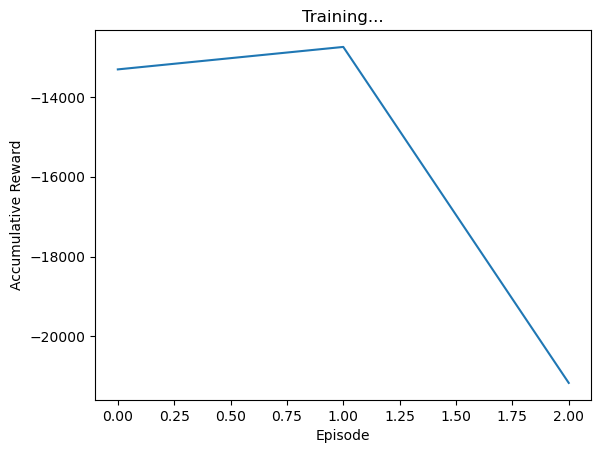

100%|██████████| 3/3 [1:57:23<00:00, 2347.94s/it]


In [6]:
from kube_mm_scheduler.model.dqn import DQN

dqn_trained = DQN(True, True)

dqn_trained = train_w_model(dqn_trained, 'trace2017_1.csv', 3)

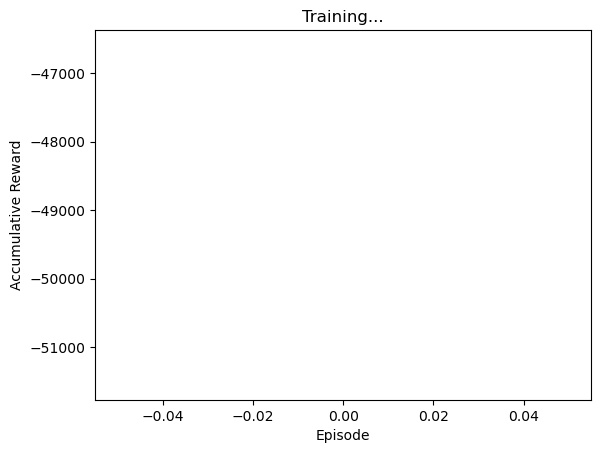

 33%|███▎      | 1/3 [2:30:48<5:01:37, 9048.90s/it]

Episode: 1, Step: 0, Reward: -0.19, # of Job scheduled: 0
Wrong shot: 1, Reward details: [-0.97, 0, 0.0, 0.0, 0.0, 0]
Episode: 1, Step: 5000, Reward: -0.18, # of Job scheduled: 1778
Wrong shot: 5001, Reward details: [-0.97, -0.8, 1, 0.78, -0.93, 0]
Episode: 1, Step: 10000, Reward: -0.67, # of Job scheduled: 2474
Wrong shot: 10001, Reward details: [-0.97, -0.86, 0.0, -0.83, -0.7, 0]
Episode: 1, Step: 15000, Reward: -0.16, # of Job scheduled: 3562
Wrong shot: 15001, Reward details: [-0.97, -0.87, 1, 1, -0.97, 0]
Episode: 1, Step: 20000, Reward: -0.42, # of Job scheduled: 4238
Wrong shot: 20001, Reward details: [-0.96, -0.88, 1, -0.96, -0.32, 0]
Episode: 1, Step: 25000, Reward: -0.16, # of Job scheduled: 6077
Wrong shot: 25001, Reward details: [-0.96, -0.86, 1, 1, -0.96, 0]
Episode: 1, Step: 30000, Reward: -0.37, # of Job scheduled: 7131
Wrong shot: 30001, Reward details: [-0.96, -0.86, -0.29, -0.76, 1.0, 0]
Episode: 1, Step: 35000, Reward: -0.48, # of Job scheduled: 10974
Wrong shot: 350

 33%|███▎      | 1/3 [4:02:20<8:04:41, 14540.58s/it]


KeyboardInterrupt: 

In [7]:
from kube_mm_scheduler.model.dqn import DQN

dqn_trained = train_w_model(dqn_trained, 'trace2017_2.csv', 3)

In [ ]:
from kube_mm_scheduler.model.dqn import DQN

dqn_trained = train_w_model(dqn_trained, 'trace2017_3.csv', 3)

In [ ]:
from kube_mm_scheduler.model.dqn import DQN

dqn_trained = train_w_model(dqn_trained, 'trace2017_4.csv', 3)

In [ ]:
from kube_mm_scheduler.model.dqn import DQN

dqn_trained = train_w_model(dqn_trained, 'trace2017_5.csv', 3)

In [7]:
# Test dqn_trained model with data_1.csv

data_path = os.path.join(base_path, "dataset", "data_1.csv")
with open(data_path, 'r') as f:
    data = f.readlines()
    data = [line.strip().split(",") for line in data]
    total = len(data)

    for line in data:
        # Change the type of each element to float
        line = [float(elem) for elem in line]
        input1 = line[:10]
        input2 = line[10:12]
        label = int(line[-1])

        input1 = torch.tensor(input1, dtype=torch.float32)
        input2 = torch.tensor(input2, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        input1 = input1.unsqueeze(0)
        input2 = input2.unsqueeze(0)
        label = label.unsqueeze(0)

        output = dqn_trained(input1, input2)
        action = output.max(1)[1].view(1, 1)
        print(f"output: {output}")
        print(f"action: {action}")
        print(f"label: {label}")

        input("Press Enter to continue...")

output: tensor([[-94.0842, -94.1244, -94.1796, -94.2582, -94.1508, -94.2033]],
       grad_fn=<AddmmBackward0>)
action: tensor([[0]])
label: tensor([4.])
output: tensor([[-72.8661, -72.8953, -72.9396, -72.9943, -72.9148, -72.9529]],
       grad_fn=<AddmmBackward0>)
action: tensor([[0]])
label: tensor([1.])


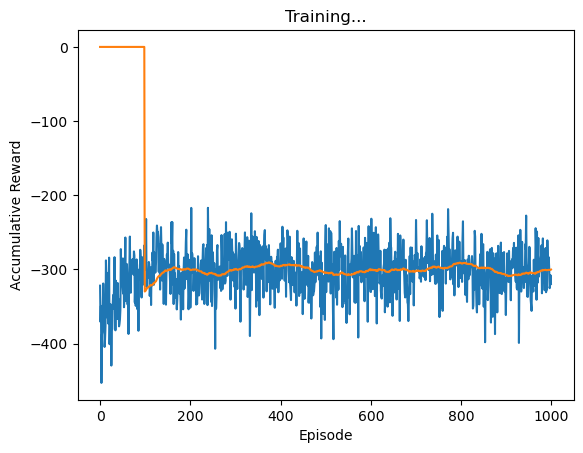

100%|██████████| 1000/1000 [49:01<00:00,  2.94s/it]


In [15]:
from net1 import Net1

net1 = Net1(False)

train_w_model(net1, 'scenario-5l-5m-1000p-30m.csv', False)

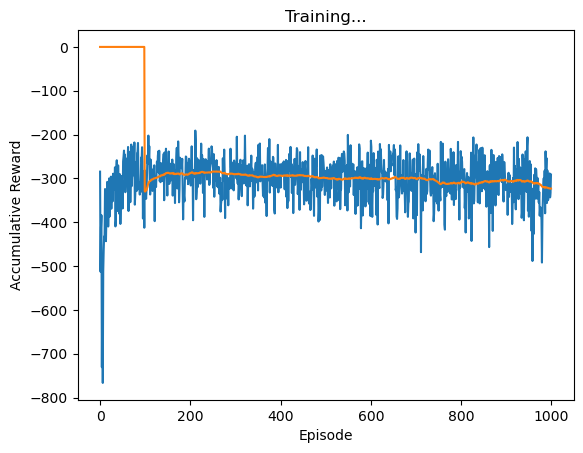

100%|██████████| 1000/1000 [48:37<00:00,  2.92s/it]


In [16]:
from net1 import Net1

net1 = Net1(True)

train_w_model(net1, 'scenario-5l-5m-1000p-30m.csv')

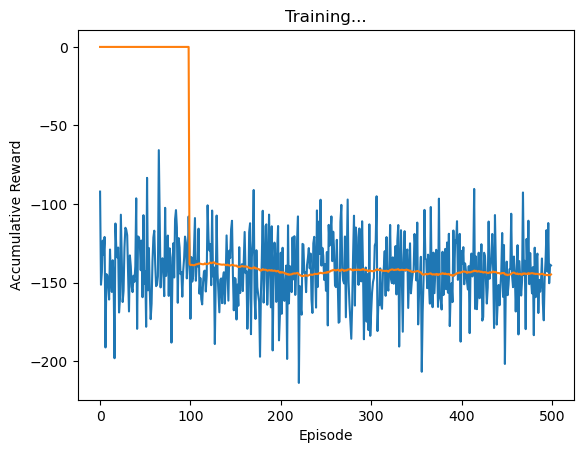

100%|██████████| 500/500 [41:31<00:00,  4.98s/it]


In [7]:
from kube_mm_scheduler.modeldqn import DQN

dqn_2 = DQN(True, False)

dqn_2 = train_w_model(dqn_2, 'scenario-5l-5m-1000p-30m.csv', 500)

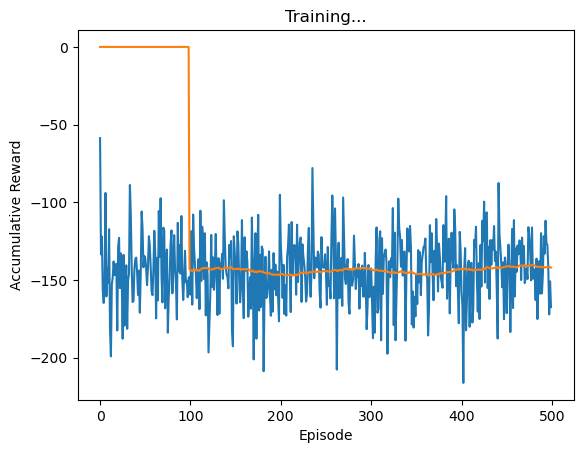

100%|██████████| 500/500 [39:27<00:00,  4.74s/it]


In [8]:
from dqn import DQN

dqn_3 = DQN(False, False)

dqn_3 = train_w_model(dqn_3, 'scenario-5l-5m-1000p-30m.csv', 500)

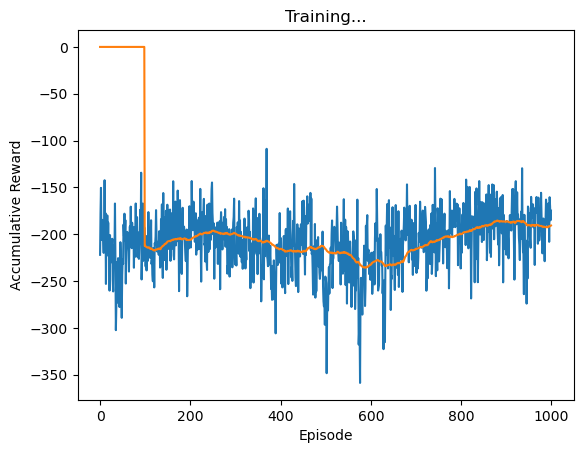

100%|██████████| 1000/1000 [1:32:27<00:00,  5.55s/it]


In [12]:
train('scenario-5l-5m-1000p-30m.csv', False)

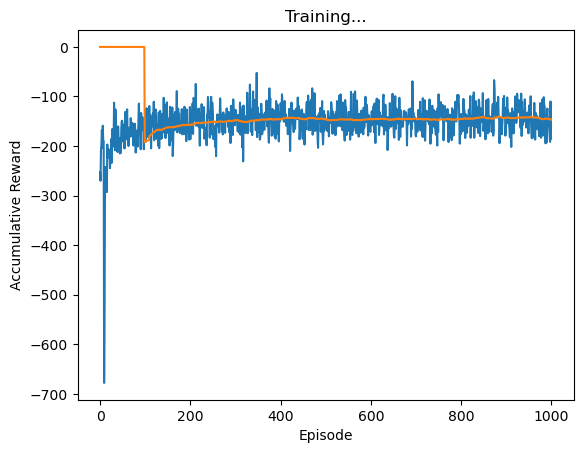

100%|██████████| 1000/1000 [1:22:53<00:00,  4.97s/it]


In [13]:
train('scenario-3l-10m-1000p-30m.csv', True)

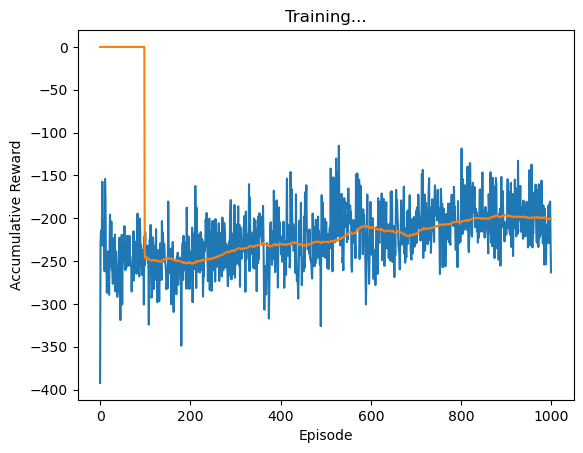

100%|██████████| 1000/1000 [1:50:41<00:00,  6.64s/it]


In [14]:
train('scenario-3l-10m-1000p-30m.csv', False)

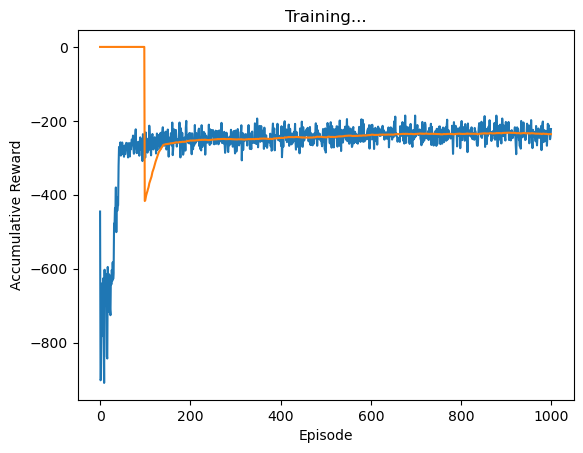

100%|██████████| 1000/1000 [1:17:57<00:00,  4.68s/it]


In [15]:
train('scenario-10l-3m-1000p-30m.csv', True)

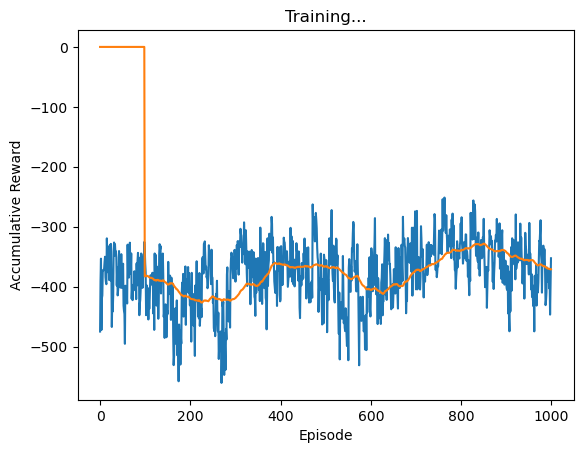

100%|██████████| 1000/1000 [1:54:36<00:00,  6.88s/it]


In [16]:
train('scenario-10l-3m-1000p-30m.csv', False)

### Test

In [2]:
sample1 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.0, 0.0]] # Ideal action : 0
sample2 = [[0.99, 0.90, 0.80, 0.80, 0.95, 0.95, 0.90, 0.85, 0.0, 0.0, 0.6, 0.7]] # Ideal action : 5
sample3 = [[0.99, 0.40, 0.20, 0.98, 0.80, 0.80, 0.20, 0.20, 0.70, 0.70, 0.5, 0.5]] # Ideal action : 4

In [3]:
from kube_mm_scheduler.model.promes import Model as Promes

promes = Promes(True, True)

Base Path: /Users/swkim/Documents/coding/thesis/PROMES_colab/notebook/..


/Users/swkim/opt/anaconda3/envs/kube-gym/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Base Path: /Users/swkim/Documents/coding/thesis/PROMES_colab/notebook/..
Base Path: /Users/swkim/Documents/coding/thesis/PROMES_colab/notebook


In [4]:
print(promes)

Model(
  (net5_): Net5_(
    (net3_): Net3_(
      (fc1_1): Linear(in_features=10, out_features=16, bias=True)
      (fc1_2): Linear(in_features=2, out_features=16, bias=True)
      (fc2): Linear(in_features=32, out_features=16, bias=True)
      (fc3): Linear(in_features=16, out_features=16, bias=True)
      (fc4): None
    )
    (fc1_3_1): Linear(in_features=2, out_features=16, bias=True)
    (fc1_3_2): Linear(in_features=2, out_features=16, bias=True)
    (fc1_3_3): Linear(in_features=2, out_features=16, bias=True)
    (fc1_3_4): Linear(in_features=2, out_features=16, bias=True)
    (fc1_3_5): Linear(in_features=2, out_features=16, bias=True)
    (fc2_1): Linear(in_features=32, out_features=16, bias=True)
    (fc3_1): None
    (fc2_2): Linear(in_features=32, out_features=16, bias=True)
    (fc3_2): None
    (fc2_3): Linear(in_features=32, out_features=16, bias=True)
    (fc3_3): None
    (fc2_4): Linear(in_features=32, out_features=16, bias=True)
    (fc3_4): None
    (fc2_5): Linear

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from kube_mm_scheduler.model.net1 import Model as Net1
from kube_mm_scheduler.model.net3 import Model as Net3
from kube_mm_scheduler.model.net5 import Model as Net5
from kube_mm_scheduler.model.promes import Model as Promes

net1 = Net1(True, True)
net3 = Net3(True, True)
promes = Promes(True, True)

# predict the score for each action
def predict_score(data, model=promes):
    print(f"Sample : {data}")
    model.eval()

    if not torch.is_tensor(data):
        data = torch.tensor(data, dtype=torch.float32)

    if len(data.shape) == 1:
        data = data.unsqueeze(0)

    data1 = data[:, :10]
    data2 = data[:, 10:]
    output = model(data1, data2)
    # Softmax
    output = F.softmax(output, dim=1)

    decision = output.max(1)[1].item()
    if decision == 0:
        print("No action")
    else:
        print(f"Action: Node {decision}")

    return output

Base Path: /Users/swkim/Documents/coding/thesis/PROMES_colab/notebook/..


In [10]:
predict_score(sample1, net3)

Sample : [[0.99, 0.9, 0.8, 0.8, 0.95, 0.95, 0.9, 0.85, 0.0, 0.0, 0.0, 0.0]]
No action


tensor([[1.0000e+00, 4.3440e-44, 7.4269e-44, 7.9874e-44, 5.3249e-44, 7.1466e-44]])

In [11]:
predict_score(sample2, net3)

Sample : [[0.99, 0.9, 0.8, 0.8, 0.95, 0.95, 0.9, 0.85, 0.0, 0.0, 0.6, 0.7]]
Action: Node 5


tensor([[6.0083e-30, 4.7169e-19, 1.2441e-12, 2.5197e-22, 2.3335e-17, 1.0000e+00]])

In [12]:
predict_score(sample3, net3)

Sample : [[0.99, 0.4, 0.2, 0.98, 0.8, 0.8, 0.2, 0.2, 0.7, 0.7, 0.5, 0.5]]
Action: Node 4


tensor([[1.0313e-28, 4.9154e-24, 9.6637e-26, 2.2801e-13, 1.0000e+00, 2.7532e-11]])

In [2]:
#Get the state from the real environment with trace2017_1.csv

import gym
from kube_sim_gym import *
from kube_sim_gym.envs.sim_kube_env import SimKubeEnv

env = gym.make('SimKubeEnv-v0', scenario_file='trace2017_1.csv')
env.reset()

state = env.get_state()
state

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [3]:
env.step(1)

(array([0.02, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ], dtype=float32),
 0.0,
 False,
 {'last_pod': <kube_sim_gym.components.pod.Pod at 0x7f84f1652a30>,
  'is_scheduled': True})

In [4]:
import copy
env2 = copy.copy(env)

In [5]:
env2.step(2)

(array([0.02, 0.04, 0.02, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  ], dtype=float32),
 0.2,
 False,
 {'last_pod': <kube_sim_gym.components.pod.Pod at 0x7f84f1652b80>,
  'is_scheduled': True})

In [6]:
env.get_state()

array([0.02, 0.04, 0.02, 0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ], dtype=float32)